![Add a relevant banner image here](path_to_image)

# Text Summarization of Chat Logs Using BERT

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

The customers of Acme Communications (who own a popular messaging platform), are consistently sharing feedback that the platform is overwhelming and hard to keep up with for long threads. 
Acme’s product team has identified automated conversation summarization as a solution to this user experience challenge. 

The free version of Acme’s messaging platform allows users to participate in 20 group chats with up to 50 participants in each. The average user of the free version has 5 active chat groups with an average of 10 people in each. 

During active times (30% or more participants online), conversations often generate 100+ individual messages each hour. The average user of Acme’s platform has 1 or more conversation thread with 1000+ unread messages since their last session every 5th time they log in.

The mean time to review 100 unread messages is 5 minutes.  95% of users will spend up to 10 minutes reviewing unread messages with no issues. After 10 minutes, they begin to feel overwhelmed; 90% of users will stop reviewing messages at this time.

Users that report feeling overwhelmed by the volume of unread messages on 5 or more separate instances:
- Log into the Acme platform 60% less frequently in the next 2 weeks
- Are 30% less likely to upgrade to paid memberships
- Are 45% more likely to close their account. 
This results in missed opportunities to convert free users to paid users and increases pressure on customer acquisition teams to replace users that leave.

Acme Communications needs to create a feature that allows users to see what they’ve missed without reading every unread message. A successful implementation of this feature will improve customer retention and increase conversions from free to paid users, directly increasing the company’s user base and revenues.


## Data Understanding

Text here

In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import kagglehub
import evaluate
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    EvalPrediction,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments
)
from torch.utils.data import Dataset, DataLoader
from rouge_score import rouge_scorer


In [2]:
path = kagglehub.dataset_download("nileshmalode1/samsum-dataset-text-summarization")

print("Filepath to dataset: ", path)

Filepath to dataset:  C:\Users\markh\.cache\kagglehub\datasets\nileshmalode1\samsum-dataset-text-summarization\versions\1


In [4]:
df_samsum_train = pd.read_csv("Data/samsum-train.csv")
df_samsum_test = pd.read_csv("Data/samsum-test.csv")
df_samsum_val = pd.read_csv("Data/samsum-validation.csv")

df_samsum_train.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [5]:
# removing rows with missing data
df_samsum_train = df_samsum_train.dropna()
df_samsum_test = df_samsum_test.dropna()
df_samsum_val = df_samsum_val.dropna()

# converting all data into strings
df_samsum_train['id'] = df_samsum_train['id'].astype('string')
df_samsum_train['dialogue'] = df_samsum_train['dialogue'].astype('string')
df_samsum_train['summary'] = df_samsum_train['summary'].astype('string')
df_samsum_test['id'] = df_samsum_test['id'].astype('string')
df_samsum_test['dialogue'] = df_samsum_test['dialogue'].astype('string')
df_samsum_test['summary'] = df_samsum_test['summary'].astype('string')
df_samsum_val['id'] = df_samsum_val['id'].astype('string')
df_samsum_val['dialogue'] = df_samsum_val['dialogue'].astype('string')
df_samsum_val['summary'] = df_samsum_val['summary'].astype('string')

# creating duplicate dfs for exploration and visualization
df_train_copy = df_samsum_train.copy()
df_test_copy = df_samsum_test.copy()
df_val_copy = df_samsum_val.copy()

# adding a column to show length of strings in dialogue
df_train_copy['diag_len'] = df_train_copy['dialogue'].str.len()
df_test_copy['diag_len'] = df_test_copy['dialogue'].str.len()
df_val_copy['diag_len'] = df_val_copy['dialogue'].str.len()

# adding a column to show length of strings in summary
df_train_copy['sum_len'] = df_train_copy['summary'].str.len()
df_test_copy['sum_len'] = df_test_copy['summary'].str.len()
df_val_copy['sum_len'] = df_val_copy['summary'].str.len()

# adding a column to show ratio of summary length to dialog length
df_train_copy['sum2diag'] = df_train_copy['sum_len'] / df_train_copy['diag_len']
df_test_copy['sum2diag'] = df_test_copy['sum_len'] / df_test_copy['diag_len']
df_val_copy['sum2diag'] = df_val_copy['sum_len'] / df_val_copy['diag_len']

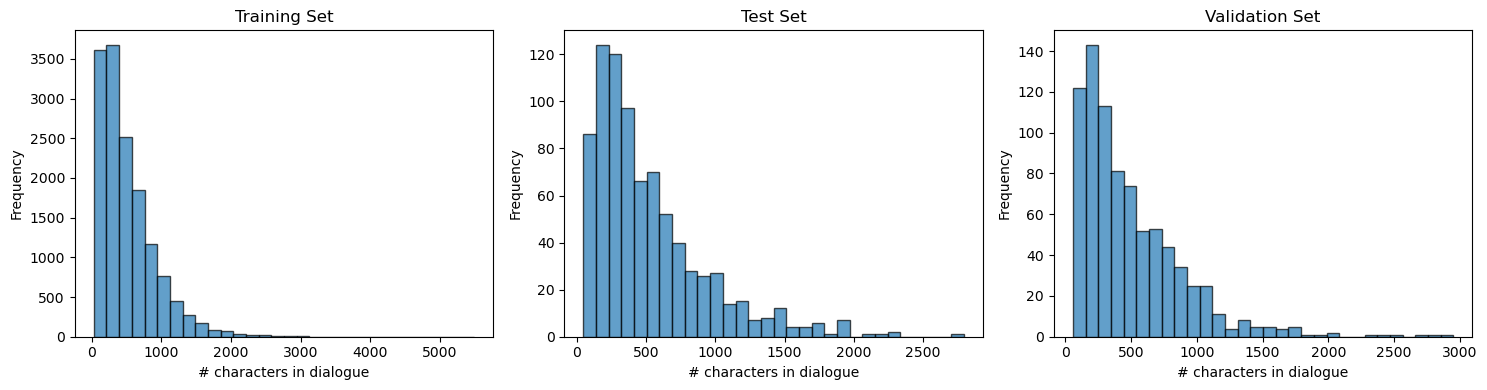

In [7]:
# figure with 3 side by side subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# histogram of dialog length for training data
axes[0].hist(df_train_copy['diag_len'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('# characters in dialogue')
axes[0].set_ylabel('Frequency')

# histogram of dialog length for test data
axes[1].hist(df_test_copy['diag_len'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Test Set')
axes[1].set_xlabel('# characters in dialogue')
axes[1].set_ylabel('Frequency')

# histogram of dialog length for validation data
axes[2].hist(df_val_copy['diag_len'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('# characters in dialogue')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

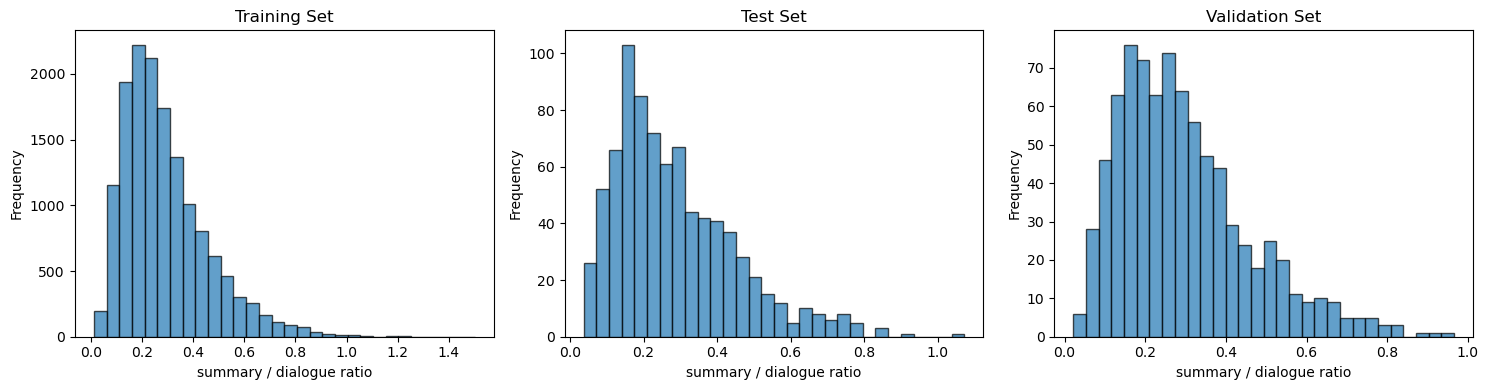

In [6]:
# 2nd figure with 3 side by side subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# histogram of summary/ dialog ratio for training data
axes[0].hist(df_train_copy['sum2diag'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('summary / dialogue ratio')
axes[0].set_ylabel('Frequency')

# histogram of summary/ dialog ratio for test data
axes[1].hist(df_test_copy['sum2diag'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Test Set')
axes[1].set_xlabel('summary / dialogue ratio')
axes[1].set_ylabel('Frequency')

# histogram of summary/ dialog ratio for validation data
axes[2].hist(df_val_copy['sum2diag'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('summary / dialogue ratio')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Data Preparation
Text here

In [8]:
# loading the Falconsai tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

In [11]:
class SummaryDataset(Dataset):
    # initializing the dataset with a tokenizer, data, and maximum token length
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer  # tokenizer to encoding text
        self.data = data            # data with dialogue and summaries
        self.max_length = max_length # max token length

    # number of items in the dataset
    def __len__(self):
        return len(self.data)

    # retrieve an entry by index
    def __getitem__(self, idx):
        item = self.data.iloc[idx]  # row at the specified index
        dialogue = item['dialogue'] # dialogue from that row
        summary = item['summary']   # summary from that row

        # encode the dialogue as model input
        source = self.tokenizer.encode_plus(
            dialogue, 
            max_length=self.max_length, 
            padding='max_length', 
            return_tensors='pt', 
            truncation=True
        )

        # encode the summary as model target
        target = self.tokenizer.encode_plus(
            summary, 
            max_length=self.max_length, 
            padding='max_length', 
            return_tensors='pt', 
            truncation=True
        )

        # return a dict with input_ids, attention_mask, labels, and the target summary
        return {
            'input_ids': source['input_ids'].flatten(),
            'attention_mask': source['attention_mask'].flatten(),
            'labels': target['input_ids'].flatten(),
            'summary': summary 
        }

In [12]:
# creating training and validation datasets
train_data = SummaryDataset(tokenizer, df_samsum_train)
val_data = SummaryDataset(tokenizer, df_samsum_val)

## Analysis

Text here

In [ ]:
# training arguments
batch_size = 8
logging_steps = 20

train_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=logging_steps,
    use_cpu=True
)

# metrics computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    rouge_scores = rouge_metric.compute(predictions=pred, references=labels)
    return {"ROUGE-1 F1 Score: {scores['rouge1'].fmeasure:.2f}",
            "ROUGE-L F1 Score: {scores['rougeL'].fmeasure:.2f}"}

In [25]:
trainer = Trainer(model=model,
                  args=train_args,
                  train_dataset=train_data,
                  eval_dataset=val_data,
                  compute_metrics=compute_metrics,
                  processing_class=tokenizer
)

In [ ]:
trainer.train()

c:\Users\markh\.conda\envs\bert-env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


## Evaluation

### Business Insight/Recommendation 1

### Business Insight/Recommendation 2

### Business Insight/Recommendation 3

### Tableau Dashboard link

## Conclusion and Next Steps
Text here